In [3]:
from brian2 import *
from matplotlib import pyplot as plt

%matplotlib inline
seed(12345)

In [4]:
start_scope()

################################################################################
# Model parameters
################################################################################
### General parameters
duration = 0.1*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step

N_sst = 4 # Number of SST neurons (inhibitory)
N_pv = 4  # Number of PV neurons (inhibitory)
N_cc = 4  # Number of CC neurons (excitatory)
N_cs = 4  # Number of CS neurons (excitatory)

### Neuron parameters
tau_S   = 16*ms  # 
tau_D   =  7*ms  #
tau_SST = 20*ms  #
tau_PV  = 10*ms  #
tau_E   =  5*ms  # Excitatory synaptic time constant
tau_I   = 10*ms  # Inhibitory synaptic time constant

C_S   = 370*pF
C_D   = 170*pF
C_SST = 100*pF
C_PV  = 100*pF

E_l  = -70*mV   # leak reversal potential
E_e  =   0*mV   # Excitatory synaptic reversal potential
E_i  = -80*mV   # Inhibitory synaptic reversal potential

V_t  = -50*mV   # spiking threashold
V_r  = E_l      # reset potential

c_d = 2600 * pA  # back-propagates somatic spikes to to the dendrites
g_s = 1300 * pA  # propagates dendritic regenerative activity to soma
g_d = 1200 * pA  # propagates dendritic regenerative activity to denderites



### Synapse parameters
w_e = 0.05*nS  # Excitatory synaptic conductance
w_i = 1.0*nS   # Inhibitory synaptic conductance


### External Input
g = 270*pA
M = 1.05 
I_ext_sst = [g for i in range(N_sst)]
I_ext_pv = [g for i in range(N_sst)]
I_ext_cs = [0 * pA for i in range(N_sst)]
I_ext_cc = [0 * pA for i in range(N_sst)]
# I_ext_sst = [g, g*M]    # external input SST
# I_ext_pv = [g, g*M] # external input PV
# I_ext_cs = [0*pA, 0*pA] # external input CS
# I_ext_cc = [0*pA, 0*pA] # external input CC

################################################################################

In [5]:
### Sigmoid function params
E_d = -38*mV  # position control of threshold
D_d =   6*mV  # sharpness control of threshold 

# TODO see how to reference this from equation 
@check_units(x=volt, result=1)
def sigmoid(x):
    return 1/(1+np.exp(-(-x-E_d)/D_d))

In [6]:
eqs_sst_inh = '''
    dv/dt = ((E_l-v)/tau_SST + I/C_SST) : volt (unless refractory)

    dg_e/dt = -g_e/tau_E : siemens
    dg_i/dt = -g_i/tau_I : siemens

    I = I_external + I_syn : amp
    I_syn = g_e*(E_e - v) + g_i*(E_i - v) : amp
    I_external : amp
'''

eqs_pv_inh = '''
    dv/dt = ((E_l-v)/tau_PV + I/C_PV) : volt (unless refractory)

    dg_e/dt = -g_e/tau_E : siemens
    dg_i/dt = -g_i/tau_I : siemens

    I = I_external + I_syn : amp
    I_syn = g_e*(E_e - v) + g_i*(E_i - v) : amp
    I_external : amp
'''

eqs_exc = '''
    dv_s/dt = ((E_l-v_s)/tau_S + (g_s*(1/(1+exp(-(v_d-E_d)/D_d))) + I_s)/C_S) : volt (unless refractory)

    dg_es/dt = -g_es/tau_E : siemens
    dg_is/dt = -g_is/tau_I : siemens

    I_s = I_external + I_syn_s : amp
    I_syn_s = g_es*(E_e - v_s) + g_is*(E_i - v_s) : amp
    I_external : amp

    dv_d/dt = ((E_l-v_d)/tau_D + (g_d*(1/(1+exp(-(v_d-E_d)/D_d))) + c_d*K + I_d)/C_D) : volt

    dg_ed/dt = -g_ed/tau_E : siemens
    dg_id/dt = -g_id/tau_I : siemens

    I_d = I_syn_d : amp
    I_syn_d = g_ed*(E_e - v_d) + g_id*(E_i - v_d) : amp
    K : 1
'''

In [7]:
# SST Neurons
sst_neurons = NeuronGroup(N_sst, model=eqs_sst_inh, threshold='v > V_t',
                              reset='v = E_l', refractory=8.3 * ms, method='euler')
sst_neurons.set_states({'I_external': I_ext_sst})
sst_neurons.v = 'E_l + rand()*(V_t-E_l)'
sst_neurons.g_e = 'rand()*w_e'
sst_neurons.g_i = 'rand()*w_i'

# PV Neurons
pv_neurons = NeuronGroup(N_pv, model=eqs_pv_inh, threshold='v > V_t',
                             reset='v = E_l', refractory=8.3 * ms, method='euler')
pv_neurons.set_states({'I_external': I_ext_pv})
pv_neurons.v = 'E_l + rand()*(V_t-E_l)'
pv_neurons.g_e = 'rand()*w_e'
pv_neurons.g_i = 'rand()*w_i'

# CS Neurons
cs_neurons = NeuronGroup(N_cs, model=eqs_exc, threshold='v_s > V_t',
                             reset='v_s = E_l', refractory=8.3 * ms, method='euler')
cs_neurons.set_states({'I_external': I_ext_cs})
cs_neurons.v_s = 'E_l + rand()*(V_t-E_l)'
cs_neurons.v_d = -70 * mV
cs_neurons.g_es = cs_neurons.g_ed = 'rand()*w_e'
cs_neurons.g_is = cs_neurons.g_id = 'rand()*w_i'
cs_neurons.K = 1  # TODO How to initialise this?

# CC Neurons
cc_neurons = NeuronGroup(N_cc, model=eqs_exc, threshold='v_s > V_t',
                             reset='v_s = E_l', refractory=8.3 * ms, method='euler')
cc_neurons.set_states({'I_external': I_ext_cc})
cc_neurons.v_s = 'E_l + rand()*(V_t-E_l)'
cc_neurons.v_d = -70 * mV
cc_neurons.g_es = cc_neurons.g_ed = 'rand()*w_e'
cc_neurons.g_is = cc_neurons.g_id = 'rand()*w_i'
cc_neurons.K = 1  # TODO How to initialise this?

In [8]:
# CS_CS 0, CS_SST 1, CS_PV 2, SST_CS 3, PV_CS 4, CC_CC 5, CC_SST 6, CC_PV 7, SST_CC 8, PV_CC 9, CC_CS 10, SST_PV 11, SST_SST 12, PV_PV 13, PV_SST 14, 
conn_probs = [1, 0.16, 0.23, 0.18, 0.52, 0.43, 0.06, 0.26, 0.22, 0.13, 0.38, 0.09, 0.29, 0.1, 0.5, 0.14]
# conn_probs = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # ALL Connected

# SST <=> PV
conn_SST_PV = Synapses(sst_neurons, pv_neurons, on_pre='g_i+=w_i', name='SST_PV') # inhibitory
conn_SST_PV.connect(p=conn_probs[11])
conn_PV_SST = Synapses(pv_neurons, sst_neurons, on_pre='g_i+=w_i', name='PV_SST') # inhibitory
conn_PV_SST.connect(p=conn_probs[14])

# PV <=> PYR soma
## target CS soma
conn_PV_CSsoma = Synapses(pv_neurons, cs_neurons, on_pre='g_is+=w_i', name='PV_CSsoma') # inhibitory
conn_PV_CSsoma.connect(p=conn_probs[4])
conn_CSsoma_PV = Synapses(cs_neurons, pv_neurons, on_pre='g_e+=w_e', name='CSsoma_PV') # excitatory
conn_CSsoma_PV.connect(p=conn_probs[2])

## target CC soma
conn_PV_CCsoma = Synapses(pv_neurons, cc_neurons, on_pre='g_is+=w_i', name='PV_CCsoma') # inhibitory 
conn_PV_CCsoma.connect(p=conn_probs[9])
conn_CCsoma_PV = Synapses(cc_neurons, pv_neurons, on_pre='g_e+=w_e', name='CCsoma_PV') # excitatory
conn_CCsoma_PV.connect(p=conn_probs[7])

# SST <=> PYR soma
## target CS soma
conn_SST_CSsoma = Synapses(sst_neurons, cs_neurons, on_pre='g_is+=w_i', name='SST_CSsoma') # inhibitory (optional connection)
conn_SST_CSsoma.connect(p=conn_probs[3])
conn_CSsoma_SST = Synapses(cs_neurons, sst_neurons, on_pre='g_e+=w_e', name='CSsoma_SST') # excitatory
conn_CSsoma_SST.connect(p=conn_probs[1])

## taget CC soma
conn_SST_CCsoma = Synapses(sst_neurons, cc_neurons, on_pre='g_is+=w_i', name='SST_CCsoma') # inhibitory (optional connection)
conn_SST_CCsoma.connect(p=conn_probs[8])
conn_CCsoma_SST = Synapses(cc_neurons, sst_neurons, on_pre='g_e+=w_e', name='CCsoma_SST') # excitatory
conn_CCsoma_SST.connect(p=conn_probs[6])

# CC => CS 
## target CS soma
conn_SST_CCdendrite = Synapses(cc_neurons, cs_neurons, on_pre='g_es+=w_e', name='CC_CSsoma') # excitatory
conn_SST_CCdendrite.connect(p=conn_probs[10])

# self connections
conn_CSsoma_CSsoma = Synapses(cs_neurons, cs_neurons, on_pre='g_es+=w_e', name='CSsoma_CSsoma')  # excitatory
conn_CSsoma_CSsoma.connect(p=conn_probs[0])
backprop_CS = Synapses(cs_neurons, cs_neurons, on_pre={'up': 'K += 1', 'down': 'K -=1'},
                           delay={'up': 0.5 * ms, 'down': 2 * ms}, name='backprop_CS')
backprop_CS.connect(condition='i==j')  # Connect all CS neurons to themselves

conn_CCsoma_CCsoma = Synapses(cc_neurons, cc_neurons, on_pre='g_es+=w_e', name='CCsoma_CCsoma')  # excitatory
conn_CCsoma_CCsoma.connect(p=conn_probs[5])
backprop_CC = Synapses(cc_neurons, cc_neurons, on_pre={'up': 'K += 1', 'down': 'K -=1'},
                           delay={'up': 0.5 * ms, 'down': 2 * ms}, name='backprop_CC')
backprop_CC.connect(condition='i==j')  # Connect all CC neurons to themselves

conn_SST_SST = Synapses(sst_neurons, sst_neurons, on_pre='g_i+=w_i', name='SST_SST')  # inhibitory
conn_SST_SST.connect(p=conn_probs[12])

conn_PV_PV = Synapses(pv_neurons, pv_neurons, on_pre='g_i+=w_i', name='PV_PV')  # inhibitory
conn_PV_PV.connect(p=conn_probs[13])


# SST => PYR dendrite
## target CS dendrite
conn_SST_CSdendrite = Synapses(sst_neurons, cs_neurons, on_pre='g_id+=w_i', name='SST_CSdendrite') # inhibitory
conn_SST_CSdendrite.connect(p=conn_probs[3]) # not sure about this here

## target CC dendrite
conn_SST_CCdendrite = Synapses(sst_neurons, cc_neurons, on_pre='g_id+=w_i', name='SST_CCdendrite') # inhibitory
conn_SST_CCdendrite.connect(p=conn_probs[8]) # not sure about this here



WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


In [9]:
# ##############################################################################
# # Monitors
# ##############################################################################

# Record spikes of different neuron groups
spike_mon_sst = SpikeMonitor(sst_neurons)
spike_mon_pv = SpikeMonitor(pv_neurons)
spike_mon_cs = SpikeMonitor(cs_neurons)
spike_mon_cc = SpikeMonitor(cc_neurons)

# Record conductances and membrane potential of neuron ni
state_mon_sst = StateMonitor(sst_neurons, ['v', 'g_e', 'g_i'], record=[0])
state_mon_pv = StateMonitor(pv_neurons, ['v', 'g_e', 'g_i'], record=[0])
state_mon_cs = StateMonitor(cs_neurons, ['v_s', 'v_d', 'g_es', 'g_is', 'g_ed', 'g_id'], record=[0])
state_mon_cc = StateMonitor(cc_neurons, ['v_s', 'v_d', 'g_es', 'g_is', 'g_ed', 'g_id'], record=[0])

In [10]:
# ##############################################################################
# # Simulation run
# ##############################################################################

defaultclock.dt = sim_dt

run(duration, report='text')

Starting simulation at t=0. s for a duration of 100. ms
100. ms (100%) simulated in < 1s


In [23]:
len(spike_mon_cc.count)

4

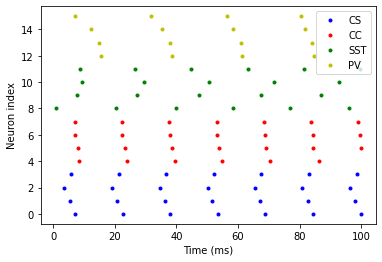

In [11]:
################################################################################
# Analysis and plotting
################################################################################

# Raster plot
plot(spike_mon_cs.t / ms, 0 + spike_mon_cs.i, '.b', label='CS')
plot(spike_mon_cc.t / ms, N_cs + spike_mon_cc.i, '.r', label='CC')
plot(spike_mon_sst.t / ms, (N_cs + N_cc) + spike_mon_sst.i, '.g', label='SST')
plot(spike_mon_pv.t / ms, (N_cs + N_cc + N_sst) + spike_mon_pv.i, '.y', label='PV')
xlabel('Time (ms)')
ylabel('Neuron index');
legend(loc='best')

Spike times CS: [ 3.6  5.4  5.8  7.1 19.1 20.8 21.3 22.6 34.6 36.2 36.7 38.  50.1 51.6
 52.1 53.4 65.6 67.1 67.6 68.9 80.9 82.6 83.1 84.4 96.3 98.  98.5 99.8] ms


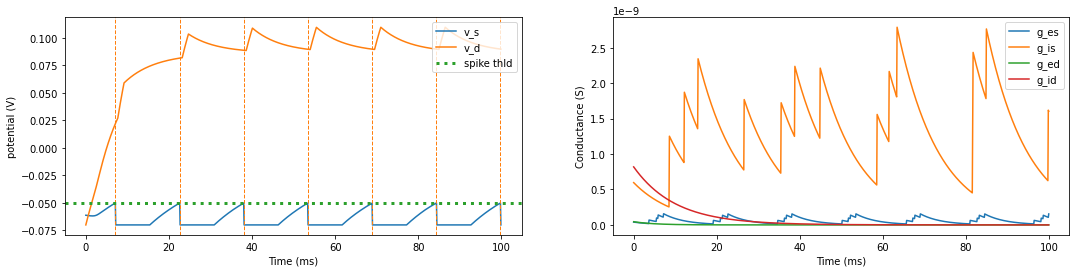

In [12]:
# CS Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_cs.t / ms, state_mon_cs.v_s[0], label='v_s')
plot(state_mon_cs.t / ms, state_mon_cs.v_d[0], label='v_d')
for (t, i) in zip(spike_mon_cs.t, spike_mon_cs.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_cs.t / ms, state_mon_cs.g_es[0], label='g_es')
plot(state_mon_cs.t / ms, state_mon_cs.g_is[0], label='g_is')
plot(state_mon_cs.t / ms, state_mon_cs.g_ed[0], label='g_ed')
plot(state_mon_cs.t / ms, state_mon_cs.g_id[0], label='g_id')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times CS: %s" % spike_mon_cs.t[:])

Spike times CC: [ 6.9  7.   8.   8.4 22.3 22.4 23.3 23.9 37.7 37.8 38.6 39.4 53.1 53.3
 53.9 54.9 68.4 68.9 69.2 70.5 83.7 84.3 84.5 86.2 99.1 99.7 99.8] ms


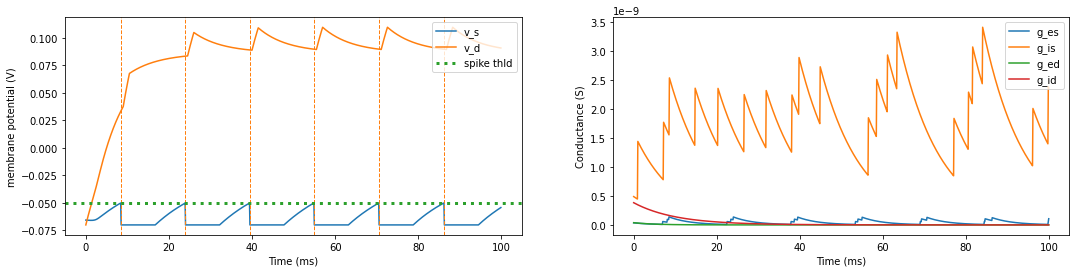

In [13]:
# CC Neurons

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_cc.t / ms, state_mon_cc.v_s[0], label='v_s')
plot(state_mon_cc.t / ms, state_mon_cc.v_d[0], label='v_d')
for (t, i) in zip(spike_mon_cc.t, spike_mon_cc.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('membrane potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_cc.t / ms, state_mon_cc.g_es[0], label='g_es')
plot(state_mon_cc.t / ms, state_mon_cc.g_is[0], label='g_is')
plot(state_mon_cc.t / ms, state_mon_cc.g_ed[0], label='g_ed')
plot(state_mon_cc.t / ms, state_mon_cc.g_id[0], label='g_id')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times CC: %s" % spike_mon_cc.t[:])

Spike times SST: [ 0.9  7.6  8.5  9.2 20.2 26.5 27.3 29.4 39.7 44.8 47.4 50.4 58.4 63.3
 67.5 71.7 77.  81.5 87.1 92.9 96.  99.7] ms


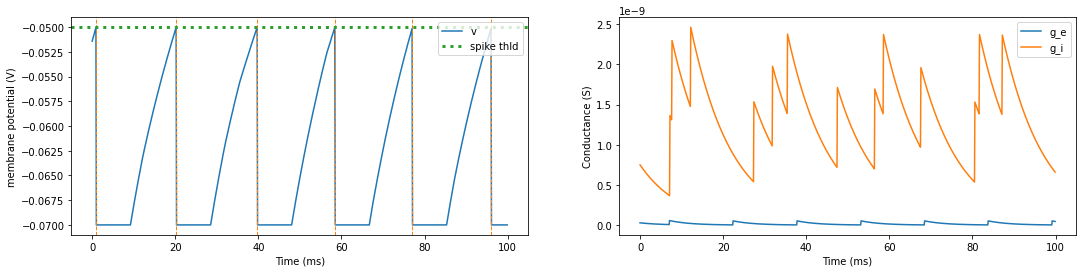

In [14]:
# SST Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_sst.t / ms, state_mon_sst.v[0], label='v')
for (t, i) in zip(spike_mon_sst.t, spike_mon_sst.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('membrane potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_sst.t / ms, state_mon_sst.g_e[0], label='g_e')
plot(state_mon_sst.t / ms, state_mon_sst.g_i[0], label='g_i')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times SST: %s" % spike_mon_sst.t[:])

Spike times PV: [ 7.1 12.1 14.7 15.4 31.8 35.4 38.  38.7 56.4 58.5 61.  61.4 80.5 81.6
 83.9 84.8] ms


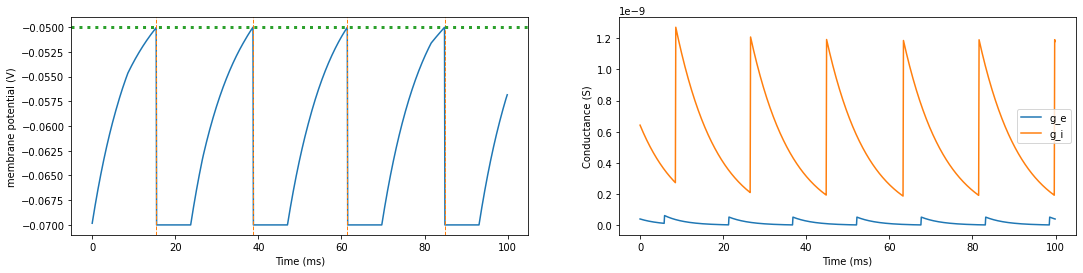

In [15]:
# PV Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_pv.t / ms, state_mon_pv.v[0], label='v')
for (t, i) in zip(spike_mon_pv.t, spike_mon_pv.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3)
xlabel('Time (ms)')
ylabel('membrane potential (V)')

subplot(1, 2, 2)
plot(state_mon_pv.t / ms, state_mon_pv.g_e[0], label='g_e')
plot(state_mon_pv.t / ms, state_mon_pv.g_i[0], label='g_i')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times PV: %s" % spike_mon_pv.t[:])